# MEI Demo

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 15

name = 'vei'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [3]:
import os
import wandb
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import seaborn as sns
import torch
from torch import load

from nnfabrik.main import *
from mei.main import MEISeed, MEIMethod
from nnfabrik.main import Dataset, my_nnfabrik
from nnsysident.tables.experiments import TrainedModel, schema
from nnsysident.tables.mei import MEISelector, TrainedEnsembleModel, MEI, MEIMonkey, MEIExperimentsMonkey, MEIExperimentsMouse
from nnvision.tables.main import Recording

device = "cuda"
random_seed = 42

Connecting konstantin@134.76.19.44:3306


TODO:
- start new eperiment with 0.5 % MEI activation and more narrow restriction to achieve this activation
- new way to achieve the variance <-> size experiment: Regularizer which punishes if the number of pixels which are unequal to their init value is greater than n -> Poisson

In [ ]:
keys = dj.AndList(["dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'", 
             "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'", 
             MEIMethod & "method_comment like '%L1%'", 
             f"unit_id in (32,  62,  68,  87,  89, 101, 131, 139, 149, 150)"
            ])
MEI.progress(keys)

MEI                  Completed 100 of 1000 (10.0%)   2023-08-16 09:27:49


(900, 1000)

In [ ]:
# Get VEI data
table = MEI & keys
# experiment_name = "Different local norms finegrained"
# table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'") & "unit_id = 6831"
score, mean, variance, method_config = (table * MEIMethod).fetch("score", "mean", "variance", "method_config")
mei = np.array(table.load_mei())
l1 = np.array([dictionary["regularization"]["kwargs"]["weight"] for dictionary in method_config])
idx = np.argsort(l1)

score = score[idx]
mean = mean[idx]
variance = variance[idx]
l1 = l1[idx]
mei = mei[idx]

# Get MEI data
mei_key = keys.copy()#.remove("method_hash")
del mei_key[2]
mei_key.append("method_hash = '54f863f93364931f53ecdfe7c2bc5a03'")
mei_key = dj.AndList(mei_key)
mei_mean, mei_variance = (MEI() & mei_key).fetch1("mean", "variance")

In [132]:
MEIExperimentsMouse().add_entry("Different L1 weights, CEI (0.6), Potential Well", 
                                "kklurz",
                                "Change the size of the CEI (0.6 MEI) using different weights of L1 regularizer. No overall norm applied, Potential Well",
                                restrictions)

In [131]:
table = pd.DataFrame((MEIExperimentsMouse.Restrictions & 'experiment_name="{}"'.format("Different L1 weights, CEI (0.8)")).proj().fetch(as_dict=True)).drop(columns="experiment_name")

old_hashes = table["method_hash"].unique()
method_hashes = (MEIMethod & "method_comment like '%CEI, 0.6%'").fetch("method_hash")

table.replace(old_hashes, method_hashes, inplace=True)
restrictions = table.to_dict("records")

In [ ]:
n_rows = 20
fig, axes = plt.subplots(n_rows, 5, figsize=(15, 2.5*n_rows), dpi=80)
fontsize = 10

for i, ax in enumerate(axes.flatten()):
    ax.imshow(mei[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(r"%$\mu$={:.3f}, %$\sigma^2$={:.3f}".format(mean[i]/mei_mean, variance[i]/mei_variance), fontsize=fontsize)
fig.tight_layout()

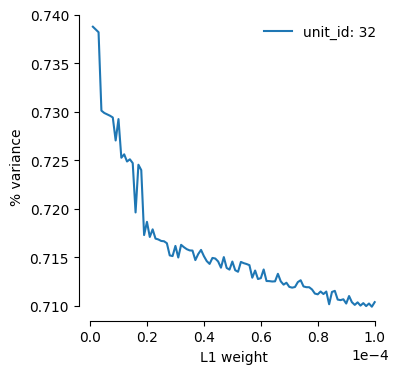

In [52]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.plot(l1, variance/mei_variance, label=f"unit_id: {unit_id}")
ax.set(xlabel="L1 weight", ylabel="% variance")
ax.legend(frameon=False)
ax.ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
sns.despine(trim=True)
# fig.savefig("Different local norms finegrained" + ".png", bbox_inches="tight", transparent=False)

100% 1/1 [00:00<00:00,  5.34it/s]


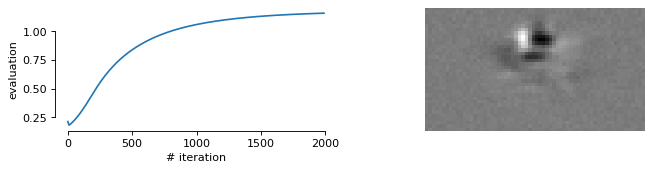

In [8]:
table = (MEI & dj.AndList(["dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'", 
             "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'", 
             "method_hash = '54f863f93364931f53ecdfe7c2bc5a03'", 
             f"unit_id = {unit_id}"]))

for u_id in tqdm(np.unique(table.fetch("unit_id"))):
    output_path = (table & f"unit_id = {u_id}").fetch1("output")
    output = load(output_path)
    mei = table.load_mei()[0]
    os.remove(output_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=80)
    axes[0].plot(
        output["mei.objectives.EvaluationObjective"]["times"],
        output["mei.objectives.EvaluationObjective"]["values"],
    )
    axes[1].imshow(mei.squeeze(), cmap="gray")
    axes[1].axis("off")

    axes[0].set_xlabel("# iteration")
    axes[0].set_ylabel("evaluation")
    sns.despine(trim=True)

___

## 3. Create Ensemble Model

In [ ]:
key = dict(dataset_fn="nnvision.datasets.monkey_loaders.monkey_static_loader",
           dataset_hash="075e942fd72e20d77d672d7a942ebc61",
           # model_fn="nnsysident.models.models.stacked2d_zig",
           model_hash="acca54db77f06e9f37b72900ddc57263",
           trainer_hash="69601593d387758e9ff6a5bf26dd6739")

# TrainedEnsembleModel().create_ensemble(key, comment="Monkey V1 Gamma Model, PointPooled")
TrainedEnsembleModel()

## 4. Populate Selector Table

In [188]:
TrainedEnsembleModel() & "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'"

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,ensemble_comment a short comment describing the ensemble
nnsysident.datasets.mouse_loaders.static_loaders,d4869853a4fd946b12adf99b70f9f1cf,89233087b4af73dfea4dbca1fbc841d0,"zig models, modulator, shifter, best 5 val loss out of 15 models, Jiakun dataset"


In [ ]:
restr = "dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'"
MEISelector.populate(restr)
MEISelector() & restr

## 5. Specify MEI Method Parameters

In [104]:
# method_fn = "mei.methods.gradient_ascent"
# for l1 in np.arange(0.000001, 0.0001, 0.000001):
#     l1 = round(l1, 6)
#     method_config = {'initial': {'path': 'mei.initial.OneValue', 'kwargs': {'fill_value': 0.01}},
#                      'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.}},
#                      'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                       'kwargs': {'sigma': 1}},
#                      'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                       'kwargs': {'patience': 20, "min_iter": 200}},
#                      'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                        'kwargs': {'interval': 10}}],
#                         "regularization": {
#                             "path": 'mei.legacy.ops.L1Norm',
#                             "kwargs": {"weight": l1},
#                         },
#                      'device': 'cuda',
#                      'mei_class_name': 'CEI',
#                      'ref_level': 0.6,
#                      "scale": 100,
#                      "dx": 0.02,
#                      }
#     method_comment = f"CEI, 0.6, OneValue, NoNorm, L1: {l1}, Potential Well"
#     MEIMethod().add_method(method_fn, method_config, comment=method_comment)


In [37]:
method_fn = "mei.methods.gradient_ascent"

# MEI
# method_config = {'initial': {'path': 'mei.initial.RandomNormal'},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.2}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 12}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'MEI'}
# method_comment = "MEI, norm=12"

# CEI
l1 = 0.0001
method_config = {'initial': {'path': 'mei.initial.OneValue', 'kwargs': {'fill_value': 0.01}},
                 'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.}},
                 'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
                  'kwargs': {'sigma': 1}},
                 'stopper': {'path': 'mei.stoppers.EarlyStopping',
                  'kwargs': {'patience': 20, "min_iter": 200}},
                 'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                   'kwargs': {'interval': 10}}],
                    "regularization": {
                        "path": 'mei.legacy.ops.L1Norm',
                        "kwargs": {"weight": l1},
                    },
                 'device': 'cuda',
                 'mei_class_name': 'CEI',
                 'ref_level': 0.8,
                 }
method_comment = f"CEI, 0.8, OneValue, NoNorm, L1: {l1}"

# VEI from CEI
# method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {"mei_type": "CEI", "ref_level": 0.8}},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.05}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 10}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'VEI',
#                  'ref_level': 0.8,
#                  "variance_optimization": "min",
#                  "scale": 100,
#                  "dx": 0.02,
#                  }
# method_comment = "VEI-, 0.8, 0.02"

# VEI from MEI
# method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {"mei_type": "MEI"}},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.05}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 10}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'VEI',
#                  'ref_level': 1.,
#                  "variance_optimization": "min",
#                  "scale": 100,
#                  "dx": 0.02,
#                  }
# method_comment = "VEI-, 1., 0.02"

MEIMethod().add_method(method_fn, method_config, comment=method_comment)
MEIMethod()

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
mei.methods.gradient_ascent,01679b74c7b4c10747f7fe3804a95784,=BLOB=,2023-08-10 17:51:13,"CEI, 0.8, OneValue, localnorm=2.36"
mei.methods.gradient_ascent,047da1f26b877b72c77c082c2383747b,=BLOB=,2023-08-10 12:08:01,"CEI, 0.8, OneValue, localnorm=2.0"
mei.methods.gradient_ascent,06d3810135ef79811be0c8b7bcae9482,=BLOB=,2023-06-19 15:55:33,"CEI, 0.8"
mei.methods.gradient_ascent,0a324bd5879a44b8c0c48fbfce510f13,=BLOB=,2023-08-10 17:51:11,"CEI, 0.8, OneValue, localnorm=1.66"
mei.methods.gradient_ascent,0a852c7076bda4455bf479afa424651c,=BLOB=,2023-08-10 12:08:00,"CEI, 0.8, OneValue, localnorm=0.5"
mei.methods.gradient_ascent,0b6f27c513db4bcbbae7eb6347966e70,=BLOB=,2023-08-10 17:51:13,"CEI, 0.8, OneValue, localnorm=2.26"
mei.methods.gradient_ascent,0c2f0201b51ab45ce0b0ee7cffa18531,=BLOB=,2023-08-10 17:51:13,"CEI, 0.8, OneValue, localnorm=2.38"
mei.methods.gradient_ascent,0f440d0ddb244eae0caa7a98b2c8373d,=BLOB=,2023-08-10 17:51:12,"CEI, 0.8, OneValue, localnorm=1.84"
mei.methods.gradient_ascent,167c23427399cc8ac5f921f1e8368ef0,=BLOB=,2023-08-10 17:51:12,"CEI, 0.8, OneValue, localnorm=1.86"
mei.methods.gradient_ascent,1904334db86967b3aa7d4340dfd1c42c,=BLOB=,2023-08-14 20:58:11,"CEI, 0.8, OneValue, NoNorm, L1: 0.00075"


In [ ]:
(MEIMethod & "method_comment like '%VEI%'")#.delete()

## 9. Plot Evaluations Across Time

In [ ]:
vei_method_hash = (MEIMethod() & "method_comment like '%MEI%'").fetch1("method_hash")
table = (MEI() & dict(ensemble_hash=ensemble_hash, method_hash=vei_method_hash)) #, unit_id=unit_ids[3]

In [ ]:
for u_id in tqdm(np.unique(table.fetch("unit_id"))):
    mei_path, output_path = (table & f"unit_id = {u_id}").fetch1("mei", "output")
    output = load(output_path)
    mei = load(mei_path)
    os.remove(output_path)
    os.remove(mei_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=80)
    axes[0].plot(
        output["mei.objectives.EvaluationObjective"]["times"],
        output["mei.objectives.EvaluationObjective"]["values"],
    )
    axes[1].imshow(mei.squeeze(), cmap="gray")
    axes[1].axis("off")

    axes[0].set_xlabel("# iteration")
    axes[0].set_ylabel("evaluation")
    sns.despine(trim=True)

### Mouse

In [116]:
experiment_name = "Different local norms finegrained"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'") & "unit_id = 6831"
score, mean, variance, method_config = (table * MEIMethod).fetch("score", "mean", "variance", "method_config")
# mei = np.array(table.load_mei())
localnorm = np.array([dictionary["postprocessing"]["kwargs"]["local_norm"] for dictionary in method_config])
idx = np.argsort(localnorm)

score = score[idx]
mean = mean[idx]
variance = variance[idx]
localnorm = localnorm[idx]
# mei = mei[idx]

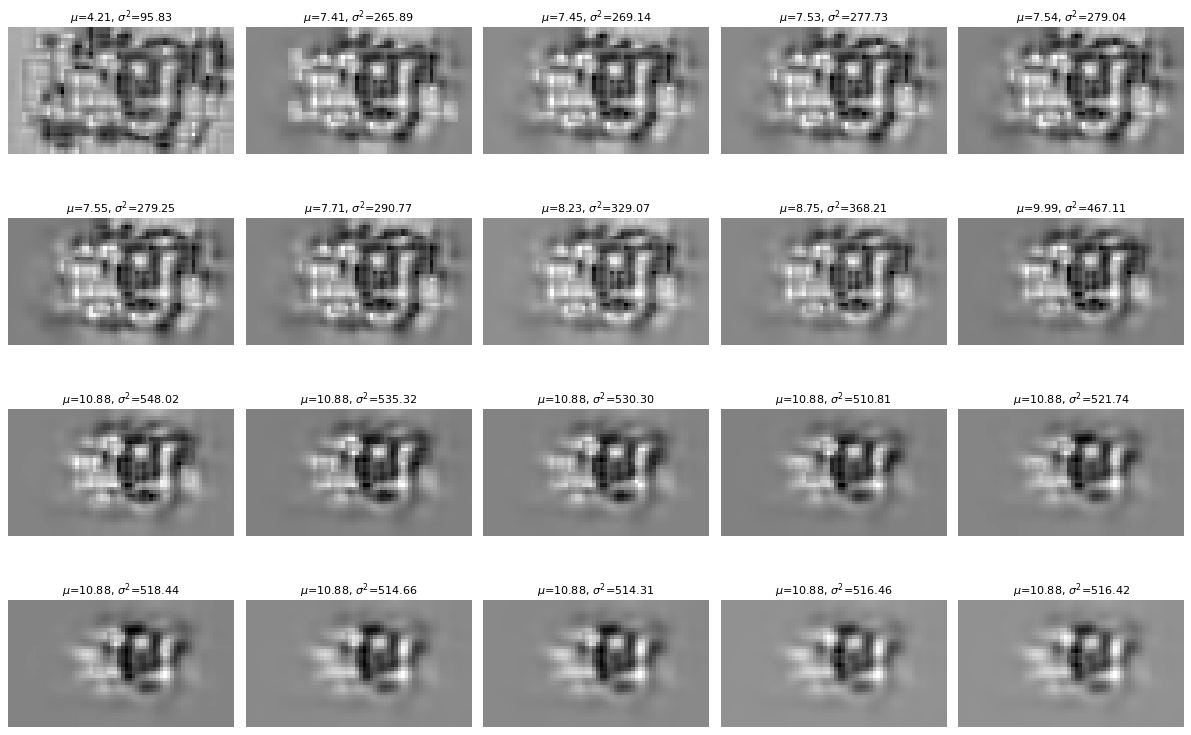

In [39]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10), dpi=80)
fontsize = 10

for i, ax in enumerate(axes.flatten()):
    ax.imshow(mei[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(r"$\mu$={:.2f}, $\sigma^2$={:.2f}".format(mean[i], variance[i]), fontsize=fontsize)
fig.tight_layout()

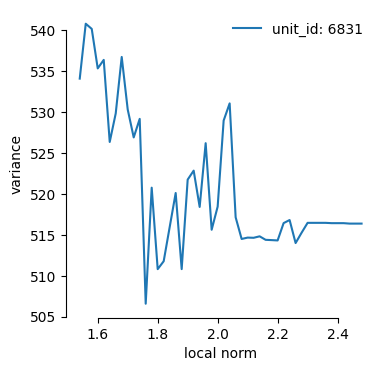

In [125]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

idx = np.where(np.diff(mean) == 0.)[0][0]
ax.plot(localnorm[idx:], variance[idx:], label="unit_id: 6831")
ax.set(xlabel="local norm", ylabel="variance")
ax.legend(frameon=False)
sns.despine(trim=True)
# fig.savefig("Different local norms finegrained" + ".png", bbox_inches="tight", transparent=False)

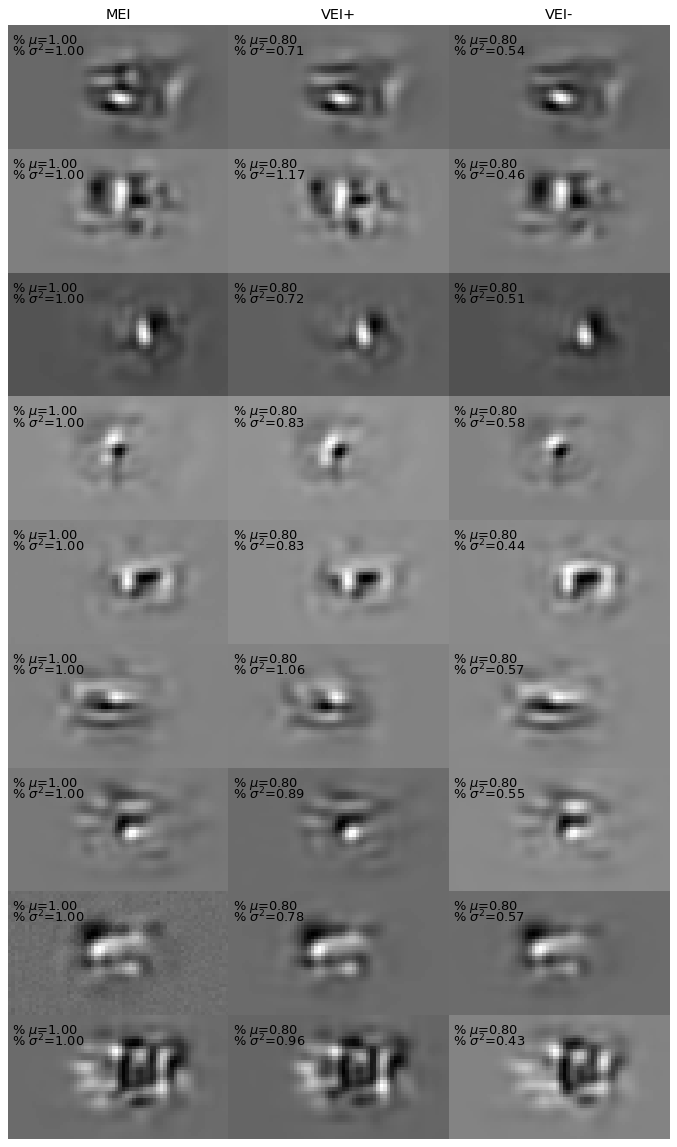

In [31]:
experiment_name = "Zhiwei0, alternative ensemble, OneValue init"
model_types = ["MEI", "VEI+", "VEI-"]


if "Monkey" in experiment_name:
    ratio = 1
    mei_table = MEIMonkey
    experiment_table = MEIExperimentsMonkey
    dpi=130
else:
    ratio = 64/36
    mei_table = MEI
    experiment_table = MEIExperimentsMouse
    dpi = 80
    
data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()

fig, axes = plt.subplots(len(finished_unit_ids), len(model_types), figsize=(2*ratio*len(model_types), 2*len(finished_unit_ids)+.3), dpi=dpi)
fontsize = 13

for i in range(len(finished_unit_ids)):
    for j, mei_type in enumerate(model_types):
        method_restr = f"method_comment like '%{mei_type}%'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        if mei_type == "MEI":
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(mei_type, fontsize=fontsize)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(experiment_name + ".png", bbox_inches="tight", transparent=False)

##### Difference between VEIs

In [ ]:
data = np.empty((10, 3, 36, 64))*np.nan
for i in range(len(fig.axes)):
    x = np.ma.getdata(fig.axes[i].get_images()[0].get_array())
    data[i//3, i%3, :, :] = x

In [ ]:
fig2, axes = plt.subplots(data.shape[0], 4, figsize=(10, 15), dpi=100)
fontsize = 10
for i, x in enumerate(data):
    axes[i, 0].imshow(x[0], cmap="gray")
    axes[i, 1].imshow(x[1], cmap="gray")
    axes[i, 2].imshow(x[2], cmap="gray")
    axes[i, 3].imshow(x[1]-x[2], cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].axis("off")
    axes[i, 2].axis("off")
    axes[i, 3].axis("off")
axes[0, 0].set_title("MEI", fontsize=fontsize)
axes[0, 1].set_title("VEI+", fontsize=fontsize)
axes[0, 2].set_title("VEI-", fontsize=fontsize)
axes[0, 3].set_title("DIFF(VEIs)", fontsize=fontsize)
# fig2.savefig("diff_of_veis" + ".png", bbox_inches="tight", transparent=False)

## Norm comparison

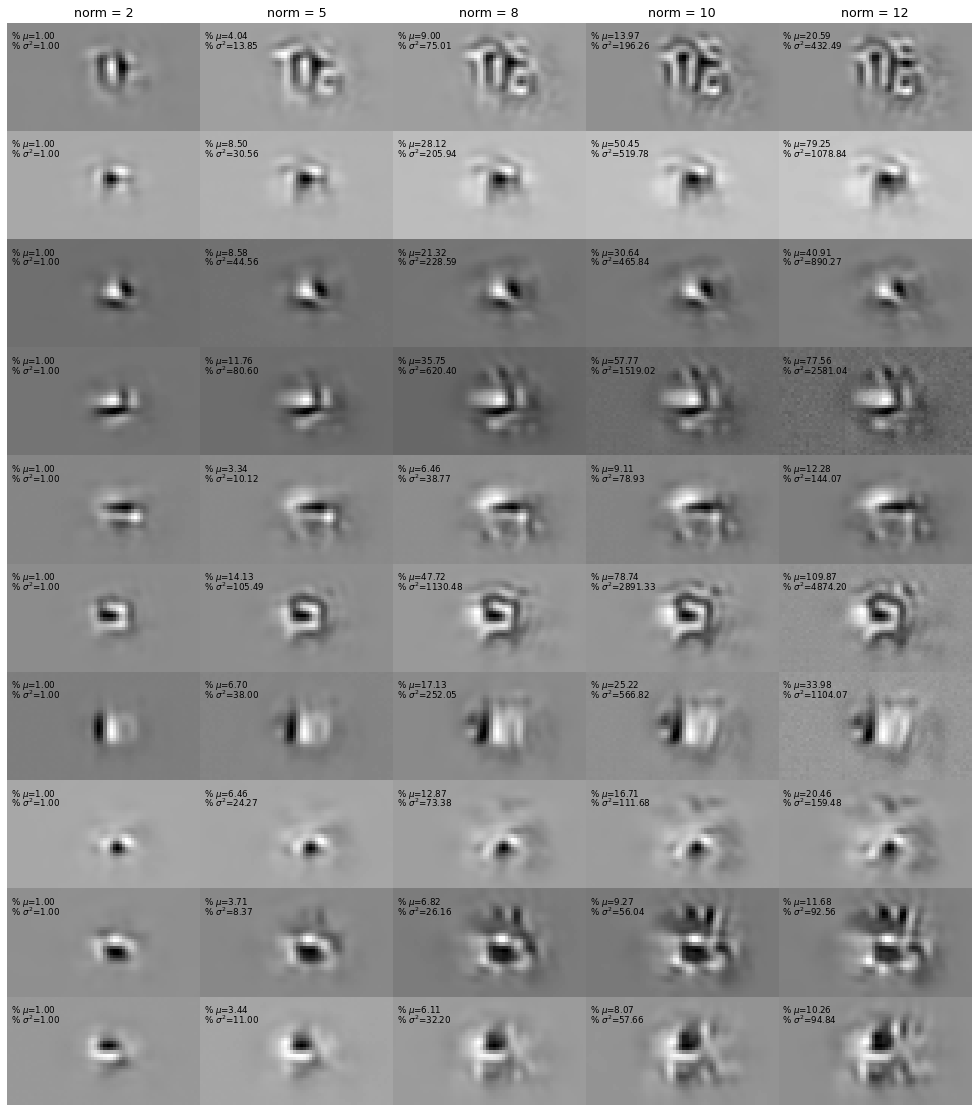

In [57]:
experiment_name = "Mouse V1, MEIs with different norm, gamma models"

data_table = mei_table() * MEIMethod & (experiment_table.Restrictions() & f"experiment_name = '{experiment_name}'")
finished_unit_ids = np.unique(data_table.fetch("unit_id"))
ensemble_comment = np.unique((data_table * TrainedEnsembleModel).fetch("ensemble_comment")).item()
methods = ['MEI, norm=2', 'MEI, norm=5', 'MEI, norm=8', 'MEI', 'MEI, norm=12']

fig, axes = plt.subplots(len(finished_unit_ids), 5, figsize=(2*ratio*5, 2*len(finished_unit_ids)+.3), dpi=70)
fontsize = 10

for i in range(len(finished_unit_ids)):
    for j, method in enumerate(methods):
        method_restr = f"method_comment = '{method}'"
        table = (data_table & f"unit_id = {finished_unit_ids[i]}" & method_restr)
        mei_path, mean, variance = table.fetch1("mei", "mean", "variance")
        norm = table.fetch1("method_config")["postprocessing"]["kwargs"]["norm"]
        
        if method == methods[0]:
            mei_mean = mean
            mei_variance = variance
        mei = load(mei_path)
        os.remove(mei_path)
        axes[i, j].imshow(mei.squeeze(), cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].text(0.02,
                        .85,
                        r"% $\mu$={:.2f}".format(mean/mei_mean),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        axes[i, j].text(0.02,
                        .75,
                        r"% $\sigma^2$={:.2f}".format(variance/mei_variance),
                        horizontalalignment='left', 
                        transform=axes[i, j].transAxes,
                        fontsize=fontsize*.9)
        if i == 0:
            axes[i, j].set_title(f"norm = {norm}", fontsize=fontsize*1.3)
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig(ensemble_comment + "_norm_comparison" + ".png", bbox_inches="tight", transparent=False)

## Get good neurons

In [68]:
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.utility.measures import get_oracles

# ensemble_comment = 'gamma models, modulator, shifter'
# ensemble_comment = 'gamma models'
ensemble_comment = 'zig models, modulator, shifter, best 5 val loss out of 15 models, Jiakun dataset'


ensemble_hash, dataset_hash = (TrainedEnsembleModel() & f"ensemble_comment = '{ensemble_comment}'").fetch1("ensemble_hash", "dataset_hash")

dataset_config = (Dataset() & f"dataset_hash = '{dataset_hash}'").fetch1("dataset_config")
dataset_config["return_test_sampler"] = True
dataset_config["tier"] = "test"
dataset_config['loader_outputs'] = ['images', 'responses']
dataset_config['subtract_behavior_mean'] = False

dataloaders = static_loaders(**dataset_config)
oracles = get_oracles(dataloaders["test"])

idx = np.argsort(oracles)
percentile = int(0.1*len(idx))
selected_idx = idx[-percentile:]
unit_ids = (MEISelector() & "unit_index in {}".format(tuple(selected_idx))).fetch("unit_id")[:10]

Returning only test sampler with repeats...


/project/nnsysident/utility/measures.py:257: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(repeated_inputs), np.array(repeated_outputs)


In [69]:
unit_ids

array([ 32,  62,  68,  87,  89, 101, 131, 139, 149, 150])

In [8]:
ensemble_comment = 'Monkey V1 Gamma Model, PointPooled'
ensemble_hash = (TrainedEnsembleModel() &
                 f"ensemble_comment = '{ensemble_comment}'").fetch1("ensemble_hash")
monkey_data_key = "3631807112901"
unit_ids = (Recording.Units() & f"data_key = '{monkey_data_key}'").fetch("unit_id")[:10]

In [125]:
print("Correlation:")
print("Poisson: " + str((TrainedModel() & "model_fn like '%poisson%'").fetch("test_correlation").mean()))
print("Gamma: " + str((TrainedModel() & "model_fn like '%gamma%'").fetch("test_correlation").mean()))
print("ZIG: " + str((TrainedModel() & "model_fn like '%zig%'").fetch("test_correlation").mean()))

print("")

print("Loss:")
print("Poisson: " + str((TrainedModel() & "model_fn like '%poisson%'").fetch("test_loss").mean()))
print("Gamma: " + str((TrainedModel() & "model_fn like '%gamma%'").fetch("test_loss").mean()))
print("ZIG: " + str((TrainedModel() & "model_fn like '%zig%'").fetch("test_loss").mean()))

Correlation:
Poisson: 0.27654999999999996
Gamma: 0.3103102
ZIG: 0.2747288

Loss:
Poisson: 0.7987650000000001
Gamma: -7.092728666666668
ZIG: -8.060051999999999


## Code for designing experiments

In [3]:
key = dj.AndList(["dataset_fn = 'nnsysident.datasets.mouse_loaders.static_loaders'",
         "dataset_hash = '77fecfed4eaa33736d47244f2c14b36b'",
         "model_fn = 'nnsysident.models.models.stacked2d_gamma'",
         "model_hash = 'ea7c8ee30c9f5ab0a632392c3a4b32c0'",
         "trainer_fn = 'nnsysident.training.trainers.standard_trainer'",
         "trainer_hash = '69601593d387758e9ff6a5bf26dd6739'",
         "seed in (6, 7, 8, 9, 10)"])
entries = (TrainedModel & key).proj().fetch(as_dict=True)
len(entries)
TrainedEnsembleModel().create_ensemble(entries, comment="gamma models, modulator, shifter, alternative ensemble0", skip_duplicates=True)

In [123]:
entries = (MEIExperimentsMouse().Restrictions()  & "experiment_name = 'Mouse V1, mu=0.8, gamma models, modulator, shifter, Zhiwei0'").proj().fetch(as_dict=True)
for entry in entries:
    entry["ensemble_hash"] = "c2c201b30ede9f7df271d45d78ba27cd"
    del entry["experiment_name"]
    # entry["data_key"] = "26614-1-16-0"
    # entry["dataset_hash"] = "2ea3ee9f182eace63e8598e029ca94a3"
    if entry["method_hash"] == "06d3810135ef79811be0c8b7bcae9482":
        entry["method_hash"] = "f36b2ca6ab7b71e91ad190192b7da9ea"

In [56]:
all_entries = []
for entry in entries:
    
    for unit_id in [1056, 3853, 1673, 2102, 6831, 4794, 6816, 6362, 5132]:
        x = entry.copy()
        x["unit_id"] = unit_id
        all_entries.append(x)

In [126]:
MEIExperimentsMouse().add_entry('Zhiwei0, alternative ensemble, OneValue init', 
                                "kklurz",
                                "MEI, CEI, VEI+, VEI- for Mouse V1 with 0.8 MEI activation, gamma models with modulator and shifter, dataset from Zhiwei, alternative ensemble0, OneValue init",
                                entries)

In [180]:
keys = [ 'dataset_fn',
 'dataset_hash',
 'ensemble_hash',
 'method_fn',
 'method_hash',
 'unit_id',
 'data_key']
entries = (MEIExperimentsMouse().Restrictions() & "experiment_name = 'Mouse V1, mu=0.8, gamma models'").proj().fetch(*keys, as_dict=True)
restrictions = []
for entry in entries:
    new_entry = entry.copy()
    new_entry["ensemble_hash"] = 'd2afd0862079b312683842967c4f9446'
    restrictions.append(new_entry)
# MEIExperimentsMouse().add_entry("Mouse V1, mu=0.8, poisson models", "kklurz", "MEI, CEI, VEI+, VEI- for Mouse V1 with 0.8 MEI activation, gamma models", restrictions, skip_duplicates=True)